In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Chemin des fichiers
# PATHFILE = "../ml-latest-small/"
PATHFILE=r"C:\Users\Hanane\Documents\Python_Scripts\TelecomParis\Module_11_Calcul_Disribue\ml-latest-small"
FILES = {"movies":"movies.csv","ratings":"ratings.csv","tags":"tags.csv"}
FILES = dict([ (k,os.path.join(PATHFILE,v)) for k,v in FILES.items()])

plt.ion()

In [2]:
# moviesframe = pd.read_csv(FILES["movies"])
# ratingframe = pd.read_csv(FILES["ratings"])
# ratingpivot = ratingframe.pivot("movieId","userId","rating").fillna(0)
#     #Numpy matrice
# ratings = ratingpivot.values
# ratings

In [5]:
def load_data():
    moviesframe = pd.read_csv(FILES["movies"])
    ratingframe = pd.read_csv(FILES["ratings"])
    ratingpivot = ratingframe.pivot("movieId","userId","rating").fillna(0)
    #Numpy matrice
    ratings = ratingpivot.values

    #dico idxML -> idx
    ml2idx = dict()
    #dico idx2ml
    idx2ml = dict()
    # Construction du dictionnaire de genres
    stylesdic = dict([(s,i) for i,s in enumerate(set(moviesframe["genres"].str.split("|").sum()))])
    #Extraction de la date
    moviesframe["date"]=moviesframe["title"].str.extract(r"\((\d\d\d\d)\)").fillna(2019)
    #Construction de la matrice description des films
    movies = np.zeros((ratings.shape[0],len(stylesdic)+3))
    for i,mlidx in enumerate(ratingpivot.index):
        movie = moviesframe[moviesframe["movieId"]==mlidx].iloc[0]
        ml2idx[mlidx]=i
        idx2ml[i]=mlidx
        styles = movie.genres.split("|")
        for s in styles:
            movies[i,stylesdic[s]]=1
        movies[i,-3]=movie.date
        #nombre de votes
        movies[i,-2]=(ratings[i]>0).sum()
        #Moyenne des votes
        movies[i,-1]=ratings[i].sum()/movies[i,-2]
    #Nombre de votes par user et par film
    nbUrates=(ratings>0).sum(0) #sum per column
    nbMrates = (ratings>0).sum(1) #sum per row

    # On nettoie les films avec moins de 10 votes
    THRESHOLD_VOTE = 10
    idx_movies = np.where(nbMrates>THRESHOLD_VOTE)[0]
    ratings = ratings[idx_movies]
    movies = movies[idx_movies]
    idx2ml =dict(zip(range(len(idx_movies)),[idx2ml[id] for id in idx_movies]))
    ml2idx = {v:k for k,v in idx2ml.items()}
    titles = {k:moviesframe[moviesframe["movieId"]==k].title.iloc[0] for k in ml2idx.keys()}
    return ratings,movies,idx2ml,ml2idx,titles,stylesdic

In [6]:
ratings,movies,idx2ml,ml2idx,titles,stylesdic=load_data()

In [27]:
#### Partie 3
from sklearn.metrics.pairwise import cosine_distances,euclidean_distances
from sklearn.neighbors import NearestNeighbors as NN

def partie3_1(ratings):
    nbUrates=(ratings>0).sum(0)
    nbMrates = (ratings>0).sum(1)
    sortedMRates = np.argsort(nbMrates)
    sortedURates = np.argsort(nbUrates)

    ## Construction des matrices de similarites users et films 
    rSortMov = ratings[sortedMRates]
    rSortUser = ratings[:,sortedURates].T
    simMovieCos = cosine_distances(rSortMov) #calculation done between two rows
    simMovieEuc = euclidean_distances(rSortMov)
    simUserCos = cosine_distances(rSortUser) #calculation done between two rows, that's why rSortUser is transposed
    simUserEuc = euclidean_distances(rSortUser)

    fig,ax = plt.subplots(2,2)

    for i,(name,im) in enumerate([("Movie cosinus",simMovieCos), ("Movie euc",simMovieEuc/simMovieEuc.max())\
        , ("User cosinus",simUserCos),("User euc",simUserEuc/simUserEuc.max())]):
        im = ax[i%2,i//2].imshow(im,interpolation=None,aspect="auto")
        fig.colorbar(im,ax=ax[i%2,i//2])
        ax[i%2,i//2].set_title(name)

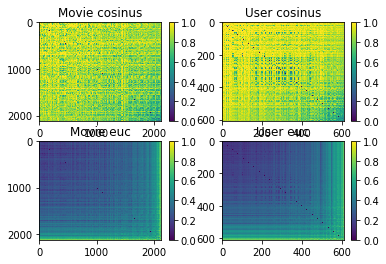

In [28]:
partie3_1(ratings)

In [29]:
## Construction du train/test  par masque aleatoire de notes
def split_test_mask(ratings,split=0.8):
    idx_ratings = list(zip(*np.nonzero(ratings))) #(id_row,id_col) of non-null ratings
    NB_RATES = len(idx_ratings) # #of non-null ratings
    shuffle_idx = np.random.permutation(idx_ratings)
    idx_train = shuffle_idx[:int(split*NB_RATES)].tolist()
    idx_test = shuffle_idx[int(split*NB_RATES):].tolist()
    ratings_train = np.array(ratings)
    for i,j in idx_test:
        ratings_train[i,j]=0.
    return ratings_train, [(m,u,ratings[m,u]) for m,u in idx_test]

In [76]:
ratings_train,ratings_test=split_test_mask(ratings,split=0.8)

In [82]:
from sklearn.metrics import roc_curve

from sklearn.metrics.pairwise import cosine_distances,euclidean_distances
from sklearn.neighbors import NearestNeighbors as NN

In [83]:
class RecoKNNUser:
    def __init__(self,ratings,metric='cosine'):
        self.matrixUM = ratings.T
        self.knn = NN(metric=metric)
        self.knn.fit(self.matrixUM)
    def get_reco_user(self,user,k=10,ponderation=False):
        dist,idx=self.knn.kneighbors(user.reshape(1,-1),n_neighbors=k)
        if not ponderation: dist=np.ones(dist.shape) 
        else: dist=np.exp(-dist)
        dist = (dist/dist.sum()).reshape(-1,1)
        avis = (self.matrixUM[idx.ravel(),:]*dist).sum(0)/(((self.matrixUM[idx.ravel(),:]!=0)*dist).sum(0)+0.00001)
        idxsort = np.argsort(-avis)
        fin = np.argmin(avis[idxsort])
        return idxsort[:fin],avis[idxsort[:fin]]

    def get_reco_user_movie(self,user,idmovie,k=10,ponderation=False):
        dist,idx=self.knn.kneighbors(user.reshape(1,-1),n_neighbors=k)
        if not ponderation: dist=np.ones(dist.shape)
        else: dist=np.exp(-dist)
        dist = (dist/dist.sum()).reshape(-1)
        avis = (self.matrixUM[idx.ravel(),idmovie]*dist).sum(0)/(((self.matrixUM[idx.ravel(),idmovie]!=0)*dist).sum(0)+0.000001)
        return avis

In [89]:
def get_reco_user_movie(knn,matrixUM,user,idmovie,k=10,ponderation=False):
        dist,idx=knn.kneighbors(user.reshape(1,-1),n_neighbors=k)
        if not ponderation: dist=np.ones(dist.shape)
        else: dist=np.exp(-dist)
        dist = (dist/dist.sum()).reshape(-1)
        avis = (matrixUM[idx.ravel(),idmovie]*dist).sum(0)/(((matrixUM[idx.ravel(),idmovie]!=0)*dist).sum(0)+0.000001)
        return avis

0 15928
100 15928
200 15928
Wall time: 4.18 s


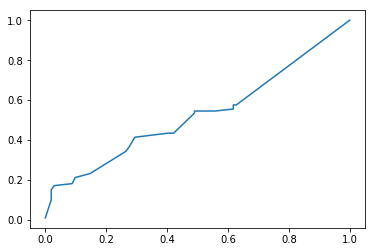

In [155]:
%%time
THRESHOLD = 3.5
ratings_train,tuple_test = split_test_mask(ratings)
K=3
ponderation=False
metric='cosine'
knn = NN(metric=metric)
knn.fit(ratings_train.T)

notes = []
test_notes = [v>THRESHOLD for i,j,v in tuple_test]
for i,(m,u,v) in enumerate(tuple_test[:201]):
    if i%100==0: print(i,len(tuple_test))
    notes.append(get_reco_user_movie(knn,ratings_train.T,ratings_train.T[u],m,K,ponderation))
fpr,tpr,ths = roc_curve(test_notes[:201],notes)
plt.plot(fpr,tpr,label=f"K-nn user-{K}-{metric}-{ponderation}")

In [154]:
print(tuple_test[:3])
u=521
idmovie=1802
ratings_train.T[u].reshape(1,-1)
dist,idx=knn.kneighbors(ratings_train.T[521].reshape(1,-1),n_neighbors=3) 
print(idx)
dist=np.ones(dist.shape)
dist = (dist/dist.sum()).reshape(-1)
print("dist",dist)
print(ratings_train.T[idx.ravel(),idmovie])
print(ratings_train.T[idx.ravel(),idmovie]*dist)
print("nominateur",(ratings_train.T[idx.ravel(),idmovie]*dist).sum(0))
print("denominateur",((ratings_train.T[idx.ravel(),idmovie]!=0)*dist).sum(0)+0.000001)
avis = (ratings_train.T[idx.ravel(),idmovie]*dist).sum(0)/(((ratings_train.T[idx.ravel(),idmovie]!=0)*dist).sum(0)+0.000001)
avis

[[521 433  62]]
dist [0.33333333 0.33333333 0.33333333]
[0.  3.5 0. ]
[0.         1.16666667 0.        ]
nominateur 1.1666666666666665
denominateur 0.3333343333333333


3.4999895000315

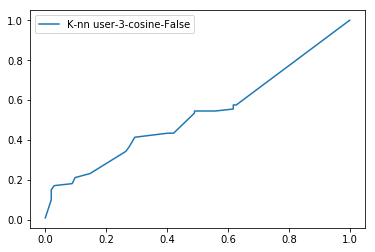

In [165]:
fpr,tpr,ths = roc_curve(test_notes[:201],notes)
plt.plot(fpr,tpr,label=f"K-nn user-{K}-{metric}-{ponderation}")
plt.legend()

In [84]:
def KNN_eval(ratings):
    THRESHOLD = 3.5
    plt.figure()
    ratings_train,tuple_test = split_test_mask(ratings)
    for K in [3,5,10]:
        for ponderation in [True,False]:
            for metric in ["cosine","euclidean"]:
                reco = RecoKNNUser(ratings_train,metric=metric)
                notes = []
                test_notes = [v>THRESHOLD for i,j,v in tuple_test]
                for i,(m,u,v) in enumerate(tuple_test):
                    if i%100==0: print(i,len(tuple_test))
                    notes.append(reco.get_reco_user_movie(ratings_train.T[u],m,K,ponderation))
                fpr,tpr,ths = roc_curve(test_notes,notes)
                plt.plot(fpr,tpr,label=f"K-nn user-{K}-{metric}-{ponderation}")
    plt.legend(loc="best")
    return notes


0 15928
100 15928
200 15928
300 15928
400 15928
500 15928
600 15928
700 15928
800 15928
900 15928
1000 15928
1100 15928
1200 15928
1300 15928
1400 15928
1500 15928
1600 15928
1700 15928
1800 15928
1900 15928
2000 15928
2100 15928
2200 15928
2300 15928
2400 15928
2500 15928
2600 15928
2700 15928
2800 15928
2900 15928
3000 15928
3100 15928
3200 15928
3300 15928
3400 15928
3500 15928
3600 15928
3700 15928
3800 15928
3900 15928
4000 15928
4100 15928
4200 15928
4300 15928
4400 15928
4500 15928
4600 15928
4700 15928
4800 15928
4900 15928
5000 15928
5100 15928
5200 15928
5300 15928
5400 15928
5500 15928
5600 15928
5700 15928
5800 15928
5900 15928
6000 15928
6100 15928
6200 15928
6300 15928
6400 15928
6500 15928
6600 15928
6700 15928
6800 15928
6900 15928
7000 15928
7100 15928
7200 15928
7300 15928
7400 15928
7500 15928
7600 15928
7700 15928
7800 15928
7900 15928
8000 15928
8100 15928
8200 15928
8300 15928
8400 15928
8500 15928
8600 15928
8700 15928
8800 15928
8900 15928
9000 15928
9100 15928


8900 15928
9000 15928
9100 15928
9200 15928
9300 15928
9400 15928
9500 15928
9600 15928
9700 15928
9800 15928
9900 15928
10000 15928
10100 15928
10200 15928
10300 15928
10400 15928
10500 15928
10600 15928
10700 15928
10800 15928
10900 15928
11000 15928
11100 15928
11200 15928
11300 15928
11400 15928
11500 15928
11600 15928
11700 15928
11800 15928
11900 15928
12000 15928
12100 15928
12200 15928
12300 15928
12400 15928
12500 15928
12600 15928
12700 15928
12800 15928
12900 15928
13000 15928
13100 15928
13200 15928
13300 15928
13400 15928
13500 15928
13600 15928
13700 15928
13800 15928
13900 15928
14000 15928
14100 15928
14200 15928
14300 15928
14400 15928
14500 15928
14600 15928
14700 15928
14800 15928
14900 15928
15000 15928
15100 15928
15200 15928
15300 15928
15400 15928
15500 15928
15600 15928
15700 15928
15800 15928
15900 15928
0 15928
100 15928
200 15928
300 15928
400 15928
500 15928
600 15928
700 15928
800 15928
900 15928
1000 15928
1100 15928
1200 15928
1300 15928
1400 15928
1500 1

1200 15928
1300 15928
1400 15928
1500 15928
1600 15928
1700 15928
1800 15928
1900 15928
2000 15928
2100 15928
2200 15928
2300 15928
2400 15928
2500 15928
2600 15928
2700 15928
2800 15928
2900 15928
3000 15928
3100 15928
3200 15928
3300 15928
3400 15928
3500 15928
3600 15928
3700 15928
3800 15928
3900 15928
4000 15928
4100 15928
4200 15928
4300 15928
4400 15928
4500 15928
4600 15928
4700 15928
4800 15928
4900 15928
5000 15928
5100 15928
5200 15928
5300 15928
5400 15928
5500 15928
5600 15928
5700 15928
5800 15928
5900 15928
6000 15928
6100 15928
6200 15928
6300 15928
6400 15928
6500 15928
6600 15928
6700 15928
6800 15928
6900 15928
7000 15928
7100 15928
7200 15928
7300 15928
7400 15928
7500 15928
7600 15928
7700 15928
7800 15928
7900 15928
8000 15928
8100 15928
8200 15928
8300 15928
8400 15928
8500 15928
8600 15928
8700 15928
8800 15928
8900 15928
9000 15928
9100 15928
9200 15928
9300 15928
9400 15928
9500 15928
9600 15928
9700 15928
9800 15928
9900 15928
10000 15928
10100 15928
10200 15

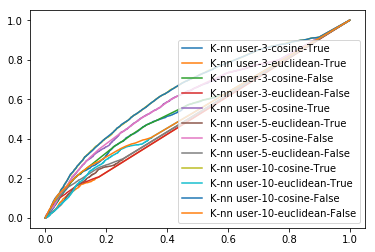

In [85]:
%%time
KNN_eval(ratings)